This notebook has been prepared by Hsiu-Wen Chang from MINES ParisTech

# Real-time object tracking with fixed background

Object tracking is a long-standing computer vision task. The task consists of two parts, detection, and tracking. For detecting objects, we can further divide algorithms into three categories: regional-based, anchor-based and keypoints methods. We will start to detect the objects in a given video with simple reginal-based method and improve the algorithms step by step. Considering the success rate of object detection is the key to the success of tracking, we shall start with regional-based method alghough it is relatively slow in inference time.

Algorithms applied in this practical lesson
1. YOLO v5 from PyTorch Hub
2. YOLO v8 from Ultralytics 


# Download mask R-CNN by uisng torchvision library

In [17]:
import torchvision
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import random

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

/bin/bash: nvcc: command not found
torch:  1.7 ; cuda:  1.7.0


In [10]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

## Download images

In [ ]:
!wget https://cloud.mines-paristech.fr/index.php/s/btteNk7PzRZ2DD2/download -q -O input1.jpg
!wget https://cloud.mines-paristech.fr/index.php/s/btteNk7PzRZ2DD2/download -q -O input2.jpg

# Run a pre-trained model to test these images

In [3]:
im1 = cv2.imread("./input1.jpg")
im2 = cv2.imread("./input2.jpg")

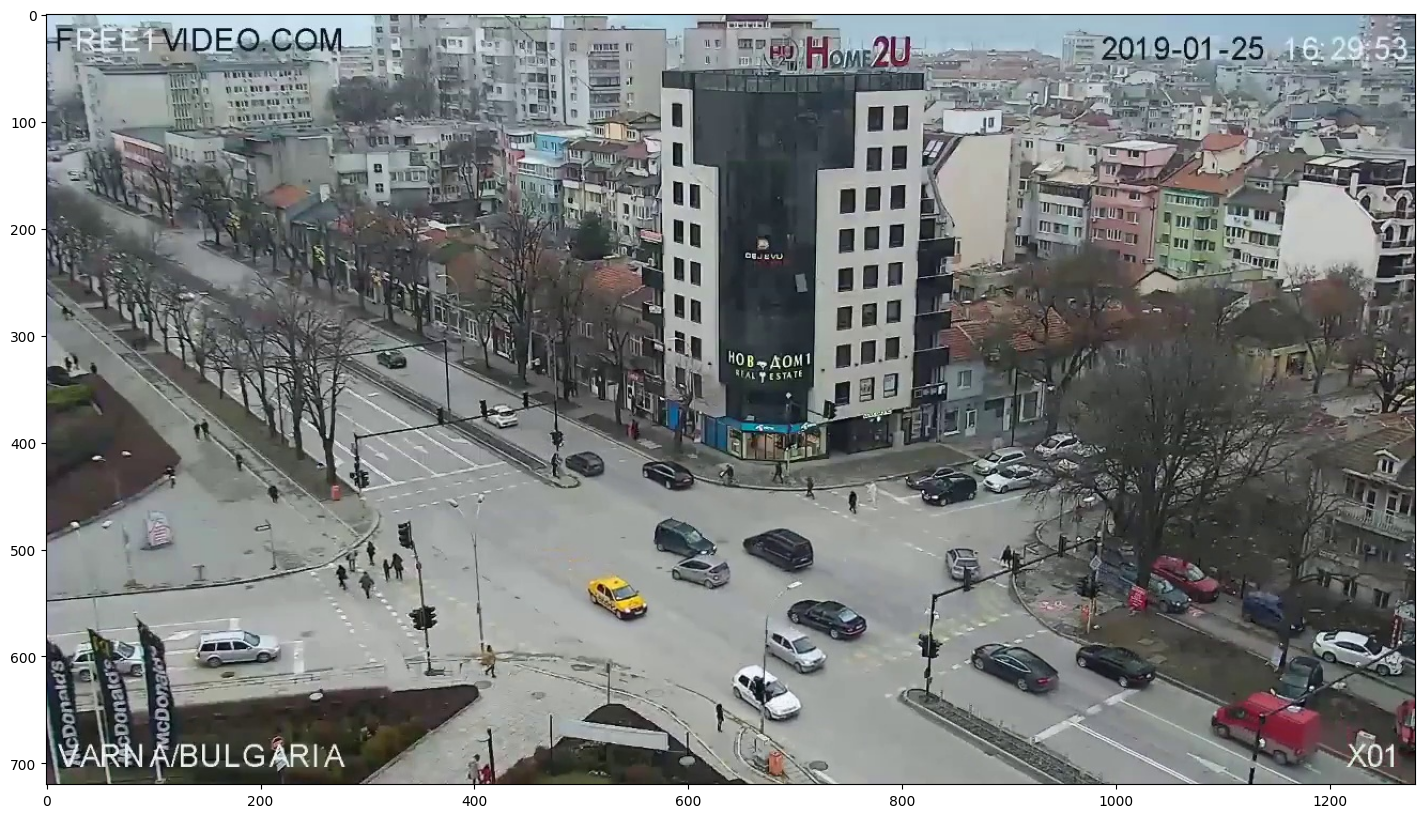

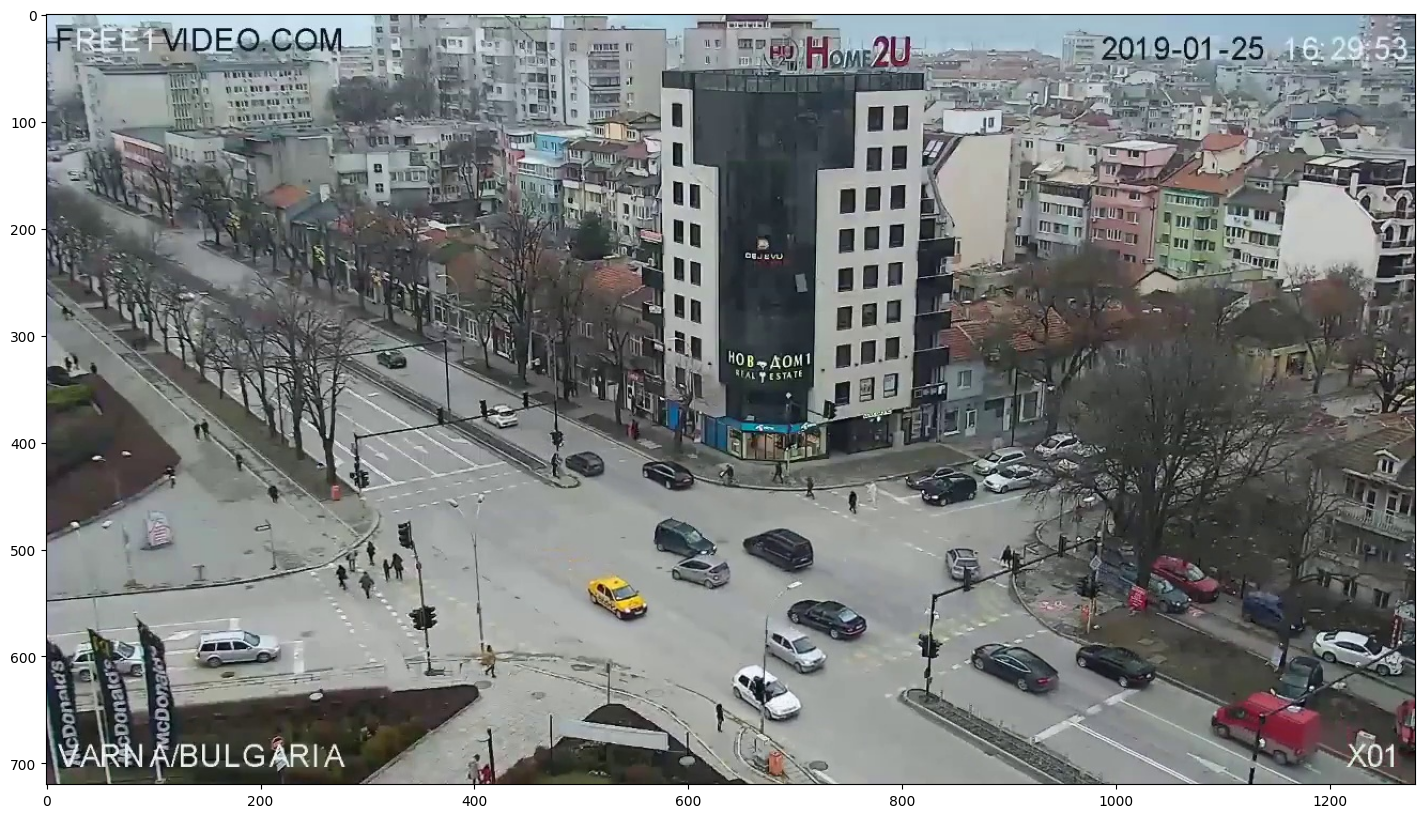

In [11]:
# if you are using Colab:
# #from google.colab.patches import cv2_imshow 
# cv2_imshow(im)

# if you are running it locally, use matplotlib
# import matplotlib.pyploy as plt
RGB_im = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.figure(figsize =(18,10))
plt.imshow(RGB_im)

RGB_im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.figure(figsize =(18,10))
plt.imshow(RGB_im2)


## Do object detection by using Mask RCNN

In [25]:
from torchvision import transforms as T

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
 
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    print(pred[0]['boxes'])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [26]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        print(boxes[i][0],boxes[i][0])
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [27]:
instance_segmentation_api('./input1.jpg')

tensor([[8.6037e+02, 5.8803e+02, 9.4927e+02, 6.3668e+02],
        [6.3958e+02, 6.0673e+02, 7.0573e+02, 6.6059e+02],
        [7.4966e+02, 4.4504e+02, 7.5894e+02, 4.6884e+02],
        [9.6141e+02, 5.8668e+02, 1.0412e+03, 6.3087e+02],
        [6.7037e+02, 5.6976e+02, 7.3046e+02, 6.1668e+02],
        [8.1449e+02, 4.2755e+02, 8.7064e+02, 4.5862e+02],
        [6.9206e+02, 5.4477e+02, 7.6880e+02, 5.8506e+02],
        [8.7606e+02, 4.2228e+02, 9.3229e+02, 4.4716e+02],
        [1.0381e+03, 5.3528e+02, 1.0708e+03, 5.6117e+02],
        [5.5638e+02, 4.1667e+02, 6.0760e+02, 4.4527e+02],
        [7.0925e+02, 4.3077e+02, 7.1944e+02, 4.5489e+02],
        [1.1835e+03, 5.7516e+02, 1.2697e+03, 6.1737e+02],
        [5.6779e+02, 4.7130e+02, 6.2889e+02, 5.0821e+02],
        [3.9369e+02, 6.9340e+02, 4.0605e+02, 7.1983e+02],
        [4.1226e+02, 3.6588e+02, 4.4245e+02, 3.8703e+02],
        [2.9967e+02, 4.9292e+02, 3.0831e+02, 5.1539e+02],
        [5.0510e+02, 5.2229e+02, 5.6112e+02, 5.6414e+02],
        [5.824

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - argument for rectangle() given by name ('color') and position (3)
>  - argument for rectangle() given by name ('color') and position (3)


**Qestion 1: what is the backbone of this pre-train model?**

**Question 2: what is the inference time for one image?**

In this example, you can see we miss the detection of a guy in th middle of the road. DANGEROUS!

Another issue here is the blue car close to the right bottom corner that we missed it. It is not a big issue since it is not on the major road. However, we should keep this in mind that do we need to track the cars that are parked on the street? 

Let's see a troublesome one

In [ ]:
instance_segmentation_api('./input2.jpg')

You should start to see more problems in this image that the detection using pre-trained model is not perfect: <br>
1. Trees could be classified to horse and indeed, do we really need to have this categories?
2. There are many missed detection of pedestrian. 
3. Missed or low confidence of object detection when the objects are partially covered by other things.

In fact, objects in the training images (such as from COCO, ImageNet) usually has high ratio of size/background. However, it is common that the objects in the surveillance video are samller than the images from the image dataset due to the tilt angle of camera, the height of the camera and etc. You are facing a problem called "Detecting small objects in the image". 

# Tasks for you to solve here for detection:
1. Improve the detection rate: how you input the information to neural network?
2. Remove the not-so-interested objects

Before you continue to do tracking of the detected objects, you should try to improve the result of object detection as much as you can. But keep in mind that some of the tracking algorithm can help in detecting the intermittent objects in a short period of time but the goal here is to provide a robust algorithm that should not fail the tracking significantly.  






 # State-of-Art algorithms in detecting small objects APs

 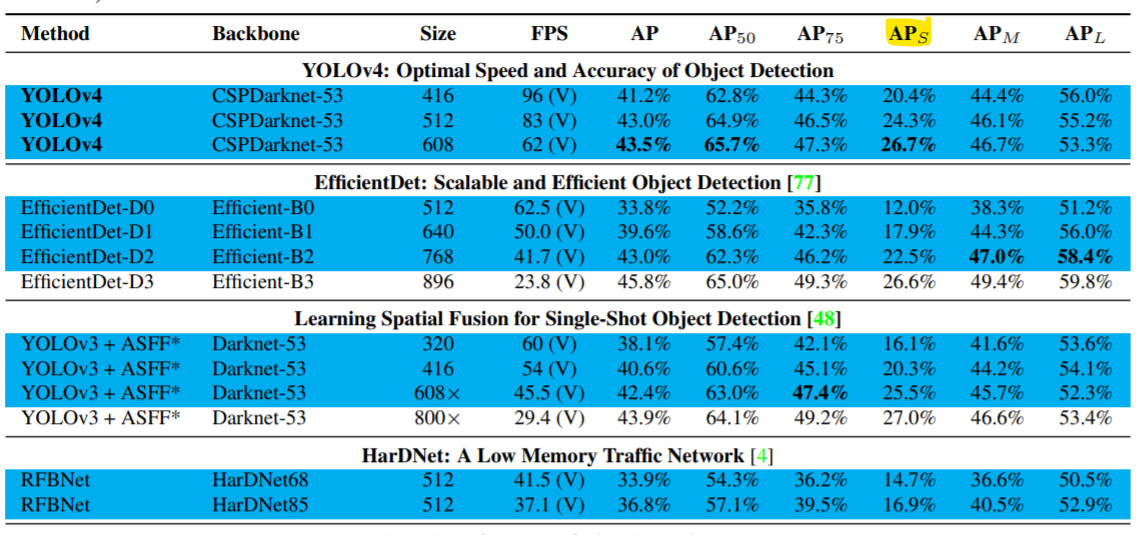


Other ways to improve the result of object detection:
1. Use the pre-trained model and train it on your own dataset: in this case you need to label the Varna video (lableImg: [https://github.com/tzutalin/labelImg]) 
2. Using sliding windows to detect objects in different runs with proper overlapping and cooridnates transformation
3. Switch to YOLOv4 which has auto learning of model anchors [https://github.com/AlexeyAB/darknet]. I can say it is going to be faster but I don't guarantee that it is better in detection :)


# Inference object detection on video
Here is the original video provided for multiple tracking of cars and pedestrian

In [29]:
# Run frame-by-frame inference demo on video with the "demo.py" tool that detectron provided in the repo.
# First video is an easier one (day time)
# Second video is at night
!wget https://cloud.mines-paristech.fr/index.php/s/T5jgr9KiTV3aaX4/download -q -O video-clip.mp4


In [30]:
from IPython.core.display import display, HTML, Video
from base64 import b64encode
mp4 = open("video-clip.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [31]:
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

python: can't open file 'detectron2/demo/demo.py': [Errno 2] No such file or directory


**Question 3: what is total inference time for this video by Detectron 2?**

# Object detection by Yolov3

We can see the Mask-RCNN is slow. For realtime application, for example, traffic monitoring, we need some thing that can run almost real-time. 

YOLO_v3 is currently among the fastest Convolutional Neural Networks for visual objects detection. [To get more information about YOLO_v3, you should go to the official YOLO page of its creator Joseph Redmon: https://pjreddie.com/darknet/yolo/](https://pjreddie.com/darknet/yolo/). Note that the corresponding original implementation is written **in C language** within the [Darknet Open Source Neural Networks C library](https://pjreddie.com/darknet/)

Yolov3 we are going to used here is from Ayoosh Kathuria](https://github.com/ayooshkathuria/pytorch-yolo-v3). Note that this PyTorch implementation of YOLO_v3 is probably slower than the original version compiled from C.

In [32]:
import os
from os.path import exists, join, basename, splitext
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
#!git clone https://github.com/ultralytics/yolov3
!wget https://cloud.mines-paristech.fr/index.php/s/ixTMf8Pu2nThZjb/download -q -O input2.jpg
#%cd yolov3
#%pip install -r requirements.txt

In [34]:
model = torch.hub.load('ultralytics/yolov8', 'yolov8')  # or yolov3-spp, yolov3-tiny, custom


Downloading: "https://github.com/ultralytics/yolov8/archive/master.zip" to /home/kelly_joly/.cache/torch/hub/master.zip


HTTPError: HTTP Error 404: Not Found

In [ ]:
image_name = './input2.jpg'
results = model(image_name)


In [ ]:
results.show()

**Question 3: what is the speed difference and which one is better?**

# (Optional) Evaluation of the performance

## Accuracy of tracking

The metrics accuracy is important to understand the performance of your algorithm. Here are the common metrics you can find:
1. Multiple object tracking precision (MOTP): total position error for matched object hypothesis pairs over all frames, averaged by the total number of matches made. 

2. MOTA: multiple object tracking Accuracy: it is composed of the ratio of misses in the sequence, ratio of false positives and ratio of mismatches. 
 
For more information, read [4]

## Tracking coverage

To know the ability of the coverage all the trajectories, we can use a table like this [1]:
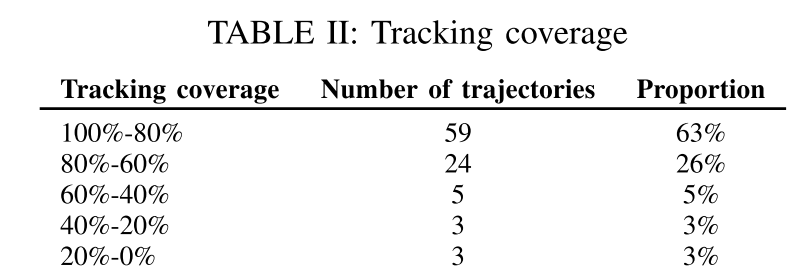

# Mini-project topic 1: track your detected object in time
Tracking detected objects either as bounding box or points, it is not easy to detect them seamlessly. In other words, the algorithm might loss it for a few frames and the objects come back later. How are we going to deal re-entering issue? 

The first idea should be obvous to you that we can create a math model to associate the time frame. This is how in 2016, SORT is proposed to solve the problem by Kalman filter. Then there are several papers start to concentrate on the issue of inference time and re-entering objects. The new algorihm, Centertrack can now generate 3D boxes of objects and track them around 30 FPS rate. You are encouraged to understand this new approach and see what is the outcome on the provided video. 

## Tracking

In real life, we would like to know when and where and even what is the object in the video. This is very improtant for traffic control, security, criminal applications. Tracking algorithms are classified into two ways:

1. Tracking by detection: One nerual network that detect the object and after that we use other independent algorithm to tracks these detected objects in time. For example, SORT [https://github.com/abewley/sort]: recommened because it is in python. There is also an enhanced version call Deep SORT.

2. Joint tracking: one neural network that do all the thing. For example, CenterTrack (State-of-art, [https://github.com/xingyizhou/CenterTrack]): pay attention that you need to compile DCNv2 (deformable convolution network) 


# Reference
1.   Clausse, A., Benslimane, S., & De La Fortelle, A. (2019). Large-scale extraction of accurate vehicle trajectories for driving behavior learning. IEEE Intelligent Vehicles Symposium, Proceedings, 2019-June, 2391–2396.
2.   Bochkovskiy, A., Wang, C.-Y., & Liao, H.-Y. M. (2020). YOLOv4: Optimal Speed and Accuracy of Object Detection.
3.   Zhou, X., Koltun, V., & Krähenbühl, P. (2020). Tracking Objects as Points. http://arxiv.org/abs/2004.01177
4. K. Bernardin and R. Stiefelhagen (2008). Evaluating multiple object tracking performance: The clear mot metrics. EURASIP Journal on Image and Video Processing, vol. 2008, p. 246309

